![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Importación librerías

#Python
import pandas as pd
import numpy as np


#Regressor Models
from xgboost import XGBRegressor

# data processing
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

# sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, power_transform, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

#Otros
import optuna
import pickle

# typing
from typing import List, Dict, Tuple, Union, Generator, Optional, Any
from pandas import DataFrame as PandasDF
from pandas import Series
from numpy import ndarray

In [27]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [28]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [29]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


In [30]:
# utils
def performance_regression_model(
        y_true: np.array, 
        y_pred: np.array,
        view_plot: bool=True,
        view_stats: bool=True
    )->Dict:
    """"""

    model_score: Dict = dict(
        r2=r2_score(y_true, y_pred),
        rmse=mean_squared_error(y_true, y_pred, squared=False),
        mse=mean_squared_error(y_true, y_pred)
    )

    if view_plot:
        pd.DataFrame({
            'predictions':y_pred,
            'residuals':y_true - y_pred         
        }).plot(
            x='predictions', y='residuals', kind='scatter',
            c='black', s=10, alpha=0.1
        )

    if view_stats:
        print('r2:', model_score.get('r2'))
        print('RMSE:', model_score.get('rmse'))
        print('mse:', model_score.get('mse'))
    
    return model_score

In [31]:
# tipos de variables
num_cols = dataTraining.select_dtypes(include='int64').columns.to_list()
target_col = num_cols[0]
num_cols = num_cols[1:]
cat_cols = dataTraining.select_dtypes(include='object').columns.to_list()

# agrupacion datos
X = pd.concat([dataTraining[num_cols], dataTraining[cat_cols].astype('category')], axis=1)
y = dataTraining[[target_col]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# preprocesamiento
numeric_pipe = make_pipeline(StandardScaler(), PowerTransformer())
categorical_pipe = make_pipeline(OneHotEncoder())
preprocessor = make_column_transformer(
    (numeric_pipe, num_cols),
    (categorical_pipe, cat_cols)
)

# canalizacion
pipe = make_pipeline(
    preprocessor, 
    XGBRegressor(enable_categorical=True)
)

In [32]:

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    
    pipe = make_pipeline(
        preprocessor, 
        XGBRegressor(**param, enable_categorical=True)
    )

    # Entrena el modelo
    pipe.fit(X_train, y_train)

    # Realiza predicciones en el conjunto de prueba
    y_pred = pipe.predict(X_test)

    # Calcula la métrica de evaluación (error cuadrático medio)
    mse = mean_squared_error(y_test, y_pred)

    return mse
    
    #model = XGBRegressor(**param)
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)
    #return mean_squared_error(y_test, y_pred)

In [33]:
# Create the study
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=500)

[I 2024-04-20 12:51:27,930] A new study created in memory with name: regression
[I 2024-04-20 12:51:33,119] Trial 0 finished with value: 17093158.99546163 and parameters: {'max_depth': 8, 'learning_rate': 0.9993736588110174, 'n_estimators': 729, 'min_child_weight': 9, 'gamma': 0.0685208349292647, 'subsample': 0.24603684796878916, 'colsample_bytree': 0.3155001571876639, 'reg_alpha': 0.06501381135267423, 'reg_lambda': 0.8260612027878464, 'random_state': 634}. Best is trial 0 with value: 17093158.99546163.
[I 2024-04-20 12:51:40,171] Trial 1 finished with value: 21111006.21601421 and parameters: {'max_depth': 10, 'learning_rate': 0.6772483383151122, 'n_estimators': 752, 'min_child_weight': 2, 'gamma': 0.35070314523009477, 'subsample': 0.242275615780107, 'colsample_bytree': 0.4760472946585965, 'reg_alpha': 0.7207100929704858, 'reg_lambda': 0.5618029462759274, 'random_state': 881}. Best is trial 0 with value: 17093158.99546163.
[I 2024-04-20 12:51:43,223] Trial 2 finished with value: 124787

In [36]:
print('Best trial', study.best_trial)

Best trial FrozenTrial(number=244, state=TrialState.COMPLETE, values=[12097226.30244433], datetime_start=datetime.datetime(2024, 4, 20, 13, 14, 8, 581819), datetime_complete=datetime.datetime(2024, 4, 20, 13, 14, 14, 227863), params={'max_depth': 5, 'learning_rate': 0.32494326222565745, 'n_estimators': 952, 'min_child_weight': 8, 'gamma': 0.1199735139394679, 'subsample': 0.9641295060646, 'colsample_bytree': 0.9443871303537072, 'reg_alpha': 0.2301747966060877, 'reg_lambda': 0.448648183034923, 'random_state': 312}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=500, step=1), 'min_child_weight': IntDistribution(high=10, log=False, low=1, step=1), 'gamma': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, l

In [37]:
print('Best parameters', study.best_params)

Best parameters {'max_depth': 5, 'learning_rate': 0.32494326222565745, 'n_estimators': 952, 'min_child_weight': 8, 'gamma': 0.1199735139394679, 'subsample': 0.9641295060646, 'colsample_bytree': 0.9443871303537072, 'reg_alpha': 0.2301747966060877, 'reg_lambda': 0.448648183034923, 'random_state': 312}


In [12]:
params1={'max_depth': 9, 'learning_rate': 0.18069902974118143, 'n_estimators': 899, 'min_child_weight': 9, 'gamma': 0.8495509043844821, 'subsample': 0.9841506910292169, 'colsample_bytree': 0.5532895608036504, 'reg_alpha': 0.35602097998099547, 'reg_lambda': 0.3585000554397834, 'random_state': 948}

In [38]:
params2 = {'max_depth': 5, 'learning_rate': 0.32494326222565745, 'n_estimators': 952, 'min_child_weight': 8, 'gamma': 0.1199735139394679, 'subsample': 0.9641295060646, 'colsample_bytree': 0.9443871303537072, 'reg_alpha': 0.2301747966060877, 'reg_lambda': 0.448648183034923, 'random_state': 312}

r2: 0.8957127642969545
RMSE: 3476.3767903056087
mse: 12085195.588175526


{'r2': 0.8957127642969545,
 'rmse': 3476.3767903056087,
 'mse': 12085195.588175526}

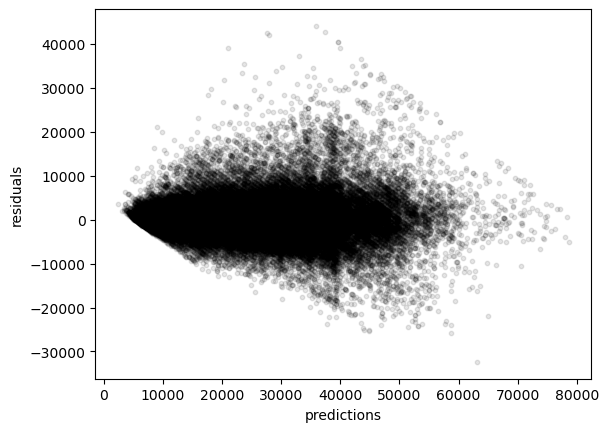

In [20]:
XGBReg_Params1_Optuna = make_pipeline(
    preprocessor, 
    XGBRegressor(enable_categorical=True,**params1)
)

XGBReg_Params1_Optuna.fit(X_train, y_train)

y_pred = XGBReg_Params1_Optuna.predict(X_test)
performance_regression_model(y_test.to_numpy().ravel(), y_pred)

r2: 0.8957127642969545
RMSE: 3476.3767903056087
mse: 12085195.588175526


{'r2': 0.8957127642969545,
 'rmse': 3476.3767903056087,
 'mse': 12085195.588175526}

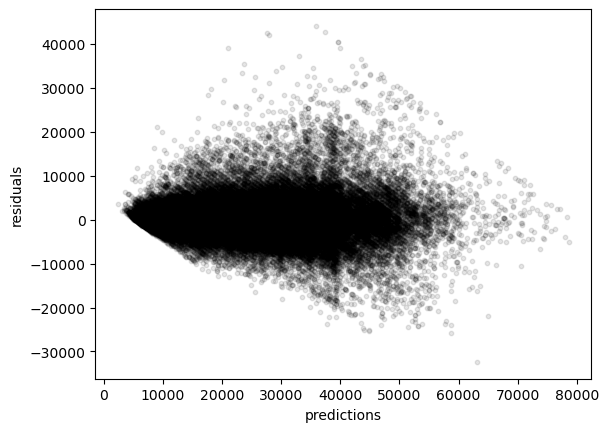

In [39]:
XGBReg_Params2_Optuna = make_pipeline(
    preprocessor, 
    XGBRegressor(enable_categorical=True,**params2)
)

XGBReg_Params2_Optuna.fit(X_train, y_train)

y_pred = XGBReg_Params1_Optuna.predict(X_test)
performance_regression_model(y_test.to_numpy().ravel(), y_pred)

# Exportacion

In [21]:
import joblib

In [22]:
joblib.dump(XGBReg_Params1_Optuna, 'model/price_xgboost_Optuna_Params.pkl', compress=3)

['model/price_xgboost_Optuna_Params.pkl']

In [23]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
y_pred_df = XGBReg_Params1_Optuna.predict(dataTesting)
y_pred_df = pd.DataFrame(dict(
    ID=range(y_pred_df.shape[0]),
    Price=y_pred_df
))

In [24]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred_df.to_csv('test_submission.csv', index=False)
y_pred_df.head()

,ID,Price
0,0,21333.666016
1,1,35790.398438
2,2,23041.042969
3,3,8648.250000
4,4,30950.257812


### Ejemplo

In [89]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

In [90]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()

,Price
ID,
0,33090.508914
1,76303.572981
2,59899.545636
3,49899.386315
4,16701.398033


# Viejo

### Encoding

In [ ]:
label_encoder = LabelEncoder()

# Aplica label encoding a la columna 'State'
dataTraining['State'] = label_encoder.fit_transform(dataTraining['State'])

# Aplica label encoding a las columnas 'Make' y 'Model'
dataTraining['Make'] = label_encoder.fit_transform(dataTraining['Make'])
dataTraining['Model'] = label_encoder.fit_transform(dataTraining['Model'])


In [ ]:
X=dataTraining[['Year', 'Mileage', 'State', 'Make', 'Model']]
y=dataTraining['Price']

### Separacion Train/Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Year', 'Mileage']])
X_test_scaled = scaler.transform(X_test[['Year', 'Mileage']])

### Modelo XGBRegressor

In [ ]:
xgb_reg = XGBRegressor(objective='reg:squarederror')

In [ ]:
xgb_reg.fit(X_train_scaled, y_train)
y_pred=xgb_reg.predict(X_test_scaled)
XGb_sin_mse=mean_squared_error(y_pred, y_test.values)
XGb_sin_r2=r2_score(y_pred, y_test.values)
XGb_sin_mae=mean_absolute_error(y_pred, y_test.values)

print(f'RMSE: {XGb_sin_mse**1/2}, R2 Score: {XGb_sin_r2}, MAE: {XGb_sin_mae}')

RMSE: 40161329.48271683, R2 Score: -1.257330776257389, MAE: 6915.933874752161


## Calibracion Modelo XGBRegressor

### Calibracion parametros Randomized Search CV

In [ ]:


# Definir los hiperparámetros a explorar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

xgb_reg_cal = XGBRegressor()

random_search = RandomizedSearchCV(xgb_reg_cal, param_distributions=param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=10, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train_scaled, y_train)


best_params_rs = random_search.best_params_
print("Mejores hiperparámetros:", best_params_rs)

XGB_RMCV = random_search.best_estimator_


Fitting 10 folds for each of 27 candidates, totalling 270 fits


KeyboardInterrupt: 

In [ ]:
y_pred = XGB_RMCV.predict(X_test_scaled)
MSEXGB=mean_squared_error(y_test, y_pred)
r2XGB=r2_score(y_test, y_pred)
MAEXGB=mean_absolute_error(y_test, y_pred)

print(f'RMSE: {MSEXGB**1/2}, R2 Score: {r2XGB}, MAE: {MAEXGB}')

RMSE: 40016286.55899231, R2 Score: 0.30436269176415165, MAE: 6910.2168050796045


### Calibracion parametros XGBoost Optuna

In [ ]:

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBRegressor(**param)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Create the study

study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=150)

[I 2024-04-19 12:59:16,846] A new study created in memory with name: regression
[I 2024-04-19 12:59:20,501] Trial 0 finished with value: 81554271.41144386 and parameters: {'max_depth': 7, 'learning_rate': 0.7231828767295525, 'n_estimators': 779, 'min_child_weight': 8, 'gamma': 0.47134607051931454, 'subsample': 0.873733947767901, 'colsample_bytree': 0.47854592833116183, 'reg_alpha': 0.5955643159911852, 'reg_lambda': 0.9739600803225049, 'random_state': 526}. Best is trial 0 with value: 81554271.41144386.
[I 2024-04-19 12:59:22,857] Trial 1 finished with value: 82067395.79642706 and parameters: {'max_depth': 6, 'learning_rate': 0.56816484939213, 'n_estimators': 527, 'min_child_weight': 5, 'gamma': 0.8497303102660381, 'subsample': 0.05471680966697649, 'colsample_bytree': 0.6340323975725317, 'reg_alpha': 0.748031575135371, 'reg_lambda': 0.7137705825890968, 'random_state': 220}. Best is trial 0 with value: 81554271.41144386.
[I 2024-04-19 12:59:26,596] Trial 2 finished with value: 81557745.0

In [ ]:
print('Best trial', study.best_trial)

NameError: name 'study' is not defined

In [ ]:
print('Best parameters', study.best_params)

NameError: name 'study' is not defined

In [ ]:
params1={'max_depth': 8, 'learning_rate': 0.01219886538844411, 'n_estimators': 915, 'min_child_weight': 10, 'gamma': 0.5554065709585313, 'subsample': 0.9280771388834574, 'colsample_bytree': 0.7536455989901876, 'reg_alpha': 0.8155919100225657, 'reg_lambda': 0.8373651705739829, 'random_state': 686}

In [ ]:
params2 =

In [ ]:
XGBRegScaledOptimizado = XGBRegressor(**params1)
XGBRegScaledOptimizado.fit(X_train_scaled, y_train)
y_predXGBRegScaledOptimizado = XGBRegScaledOptimizado.predict(X_test_scaled)

print('MSE: ', mean_squared_error(y_test, y_predXGBRegScaledOptimizado))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_predXGBRegScaledOptimizado)))

MSE:  81538416.19642115
RMSE:  9029.862468300453


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

XGBReg1 = XGBRegressor(**params1)
XGBReg1.fit(X_scaled, y)